In [1]:
%matplotlib notebook
DEFAULT_FIGSIZE = (12, 8)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint
from antlia import trial2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

In [2]:
with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

records = []
data_dir = '../../data/comfort'
i = 0
for file1, file2 in zip(bicycle_record_files, lidar_record_files):
    r1 = load_file(os.path.join(data_dir, file1), bicycle_calibration['convbike'])
    r2 = load_converted_record(os.path.join(data_dir, file2))
    r = Record(r2, r1)
    records.append(r)
    print('loaded record from files: {}, {}'.format(file1, file2))
    i += 1
    #if i >= 8:
    if i >= 0:
        break

loaded record from files: 2018-04-23_12-30-38.csv, 2018-04-23-12-17-37_0.pkl.gz


In [3]:
# notes on missing syncs and repeated trials
missing_sync = [
   [680], None, None, None, None,
   None, None, None, None, None,
   None, None, None, None, None,
   None, None
]

trial_mask = [
   None, None, 0, None, None,
   0, None, None, 9, None,
   None, 11, 8, 9, None,
   None, None
]

#assert len(missing_sync) == len(records)

for i, (r, ms, tm) in enumerate(zip(records, missing_sync, trial_mask)):
    print('calculating trials for cyclist', i)
    
    try:
        r.sync()
        r._calculate_trials2(missing_sync=ms, trial_mask=tm)
    except (AssertionError, ValueError) as e:
        print('unable to calculate trials for cyclist', i)
        print(e)

calculating trials for cyclist 0


<IPython.core.display.Javascript object>


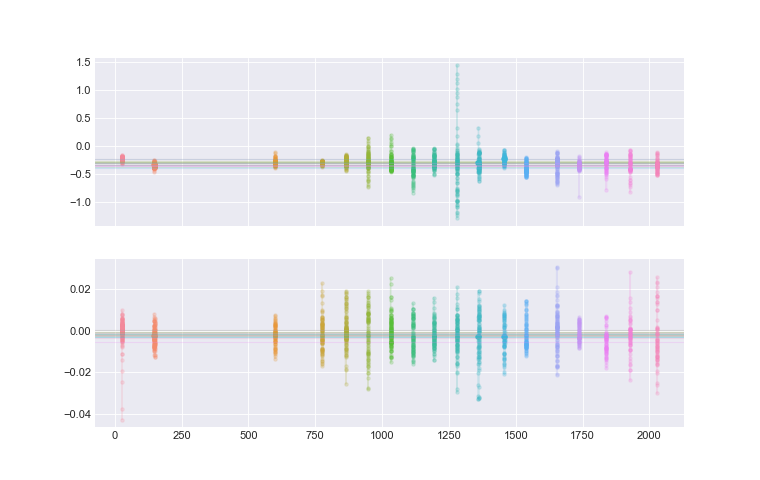

[-0.223 -0.345 -0.285 -0.297 -0.284 -0.273 -0.301 -0.371 -0.281 -0.332
 -0.304 -0.235 -0.393 -0.344 -0.348 -0.303 -0.348 -0.343]
[-0.001 -0.003 -0.002 -0.002  0.    -0.001 -0.001 -0.002 -0.002 -0.002
 -0.003 -0.003 -0.002  0.    -0.001 -0.006 -0.002 -0.004]


In [13]:
plt.close('all')

index = records[0].bicycle.sync.astype(bool)
clumps = np.ma.extras._ezclump(index)

husl_color = sns.husl_palette(len(clumps), l=0.7)
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9.5, 6))
acc = []
gyro = []
for i, c in enumerate(clumps):
    time = records[0].bicycle['time'][c]
    x = records[0].bicycle['accelerometer x'][c]
    z = records[0].bicycle['gyroscope z'][c]
    
    ax[0].plot(time, x,
               marker='.',
               color=husl_color[i], alpha=0.2)
    acc.append(x.mean())
    ax[0].axhline(x.mean(),
                  linewidth=1,
                  color=husl_color[i], alpha=0.2)
    ax[0].plot(time[[0, -1]],
               2*[x.mean()],
               linewidth=5,
               color=husl_color[i])
    
    ax[1].plot(time, z,
               marker='.',
               color=husl_color[i], alpha=0.2)
    gyro.append(z.mean())
    ax[1].axhline(z.mean(),
                  linewidth=1,
                  color=husl_color[i], alpha=0.2)
    ax[1].plot(time[[0, -1]],
               2*[z.mean()],
               linewidth=5,
               color=husl_color[i])
plt.show()
print(np.round(acc, 3))
print(np.round(gyro, 3))

[ 28.87502441   2.95006747   3.14159265   6.0385284    0.           0.        ]
[=================================================================================================== ] 99.9%

<IPython.core.display.Javascript object>


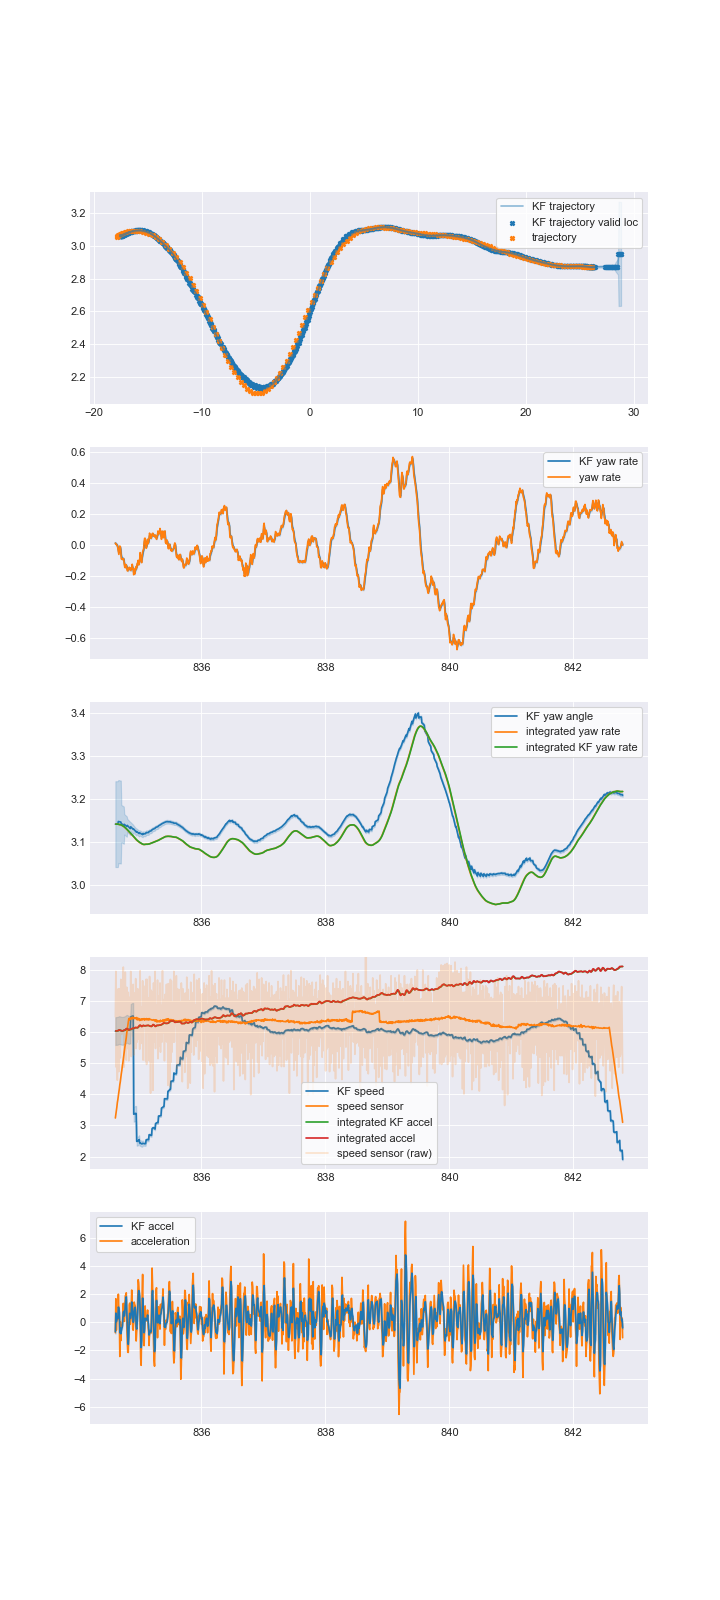

In [105]:
evt = records[0].trials[4].event
trjx, trjy = evt.trajectory(mode='interp')

T = 1/125 # bicycle sample rate
z = measurement_array(evt)
x0 = np.array([
    trjx[0:20].max() + 0.5,
    trjy[0:100].mean(),
    np.pi,
    np.abs(np.diff(trjx[:100]).mean())*20,
    0,
    0
])

P0 = np.diag([
    0.1,
    0.1,
    0.01,
    0.2,
    0.1,
    0.2
])

if x0[0] < 20:
    x0[0] = 20
    P0[0, 0] *= 10
if x0[1] < 2.5 or x0[1] > 3.5:
    x0[1] = 3
    P0[1, 1] *= 10
if x0[3] < 1:
    x0[3] = 5
    P0[3, 3] *= 10
print(x0)

q0 = 1
q1 = 0.01
Q = 1*np.diag([
    q0*T**3/3, # [m] x-position
    q0*T**3/3, # [m] y-position
    q1*T**2/2, # [rad/s] yaw angle
    q0*T**2/2, # [m/s] velocity 
    q1*T, # [rad/s] yaw rate
    q0*T, # [m/s^2] acceleration
])
R = 0.01*np.diag([
    0.01, # x
    0.01, # y
    z[:100, 2].var(),
    z[:100, 3].var(),
])

#result = kalman(f, A, h, H, x0, P0, Q, R, z, progress=True)
from antlia import kalman
#f, h, F, H = kalman.generate_fhFH(constant_velocity=True)
z = kalman.generate_measurement(evt)
result = kalman.Kalman(F, H, Q, R, f, h).estimate(x0, P0, z, [1, 1, 0, 0], progress=True)

import scipy.integrate
from antlia import filter as ff

color = sns.color_palette('tab10', 10)

x = result[0]
P = result[1]

plt.close('all')
fig, ax = plt.subplots(5, 1, figsize=(9, 20))
ax[0].plot(x[:, 0], x[:, 1], alpha=0.5, label='KF trajectory')
index = z.mask.any(axis=1)
ax[0].scatter(x[index, 0],
              x[index, 1],
              s=15, marker='X',
              color=color[0],
              label='KF trajectory valid loc')
ax[0].scatter(z[:, 0].compressed(),
              z[:, 1].compressed(),
              s=15, marker='X',
              color=color[1],
              label='trajectory')
ax[0].fill_between(x[:, 0].squeeze(),
                   x[:, 1].squeeze() + np.sqrt(P[:, 1, 1]),
                   x[:, 1].squeeze() - np.sqrt(P[:, 1, 1]),
                   color=color[0], alpha=0.2)
ax[0].legend()

ax[1].plot(evt.bicycle.time, x[:, 4], label='KF yaw rate')
ax[1].plot(evt.bicycle.time, z[:, 2], label='yaw rate')
ax[1].fill_between(evt.bicycle.time,
                   x[:, 4].squeeze() + np.sqrt(P[:, 4, 4]),
                   x[:, 4].squeeze() - np.sqrt(P[:, 4, 4]),
                   color=color[0], alpha=0.2)
ax[1].legend()

ax[2].plot(evt.bicycle.time, x[:, 2],
           label='KF yaw angle')
ax[2].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(z[:, 2], dx=T) + np.pi,
           label='integrated yaw rate')
ax[2].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(x[:, 4].squeeze(), dx=T) + np.pi,
           label='integrated KF yaw rate')
ax[2].fill_between(evt.bicycle.time,
                   x[:, 2].squeeze() + np.sqrt(P[:, 2, 2]),
                   x[:, 2].squeeze() - np.sqrt(P[:, 2, 2]),
                   color=color[0], alpha=0.2)
ax[2].legend()

ax[3].plot(evt.bicycle.time, x[:, 3], color=color[0], label='KF speed')
ax[3].plot(evt.bicycle.time, ff.moving_average(evt.bicycle.speed, 55),
           color=color[1], label='speed sensor')
ax[3].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(x[:, 5].squeeze(), dx=T) + x0[3],
           color=color[2], label='integrated KF accel')
ax[3].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(z[:, 3], dx=T) + x0[3],
           color=color[3], label='integrated accel')
ylim = ax[3].get_ylim()

ax[3].plot(evt.bicycle.time, evt.bicycle.speed,
           color=color[1], alpha=0.2, label='speed sensor (raw)')
ax[3].fill_between(evt.bicycle.time,
                   x[:, 3].squeeze() + np.sqrt(P[:, 3, 3]),
                   x[:, 3].squeeze() - np.sqrt(P[:, 3, 3]),
                   color=color[0], alpha=0.2)
ax[3].set_ylim(ylim)
ax[3].legend()

ax[4].plot(evt.bicycle.time, x[:, 5],
           zorder=2,
           color=color[0], label='KF accel')
ax[4].fill_between(evt.bicycle.time,
                   x[:, 5].squeeze() + np.sqrt(P[:, 5, 5]),
                   x[:, 5].squeeze() - np.sqrt(P[:, 5, 5]),
                   color=color[0], alpha=0.2)
ax[4].plot(evt.bicycle.time, z[:, 3],
           zorder=1,
           color=color[1], label='acceleration')
ax[4].legend()

ax[1].get_shared_x_axes().join(ax[1], ax[2])
ax[1].get_shared_x_axes().join(ax[1], ax[3])
ax[1].get_shared_x_axes().join(ax[1], ax[4])
plt.show()

<IPython.core.display.Javascript object>


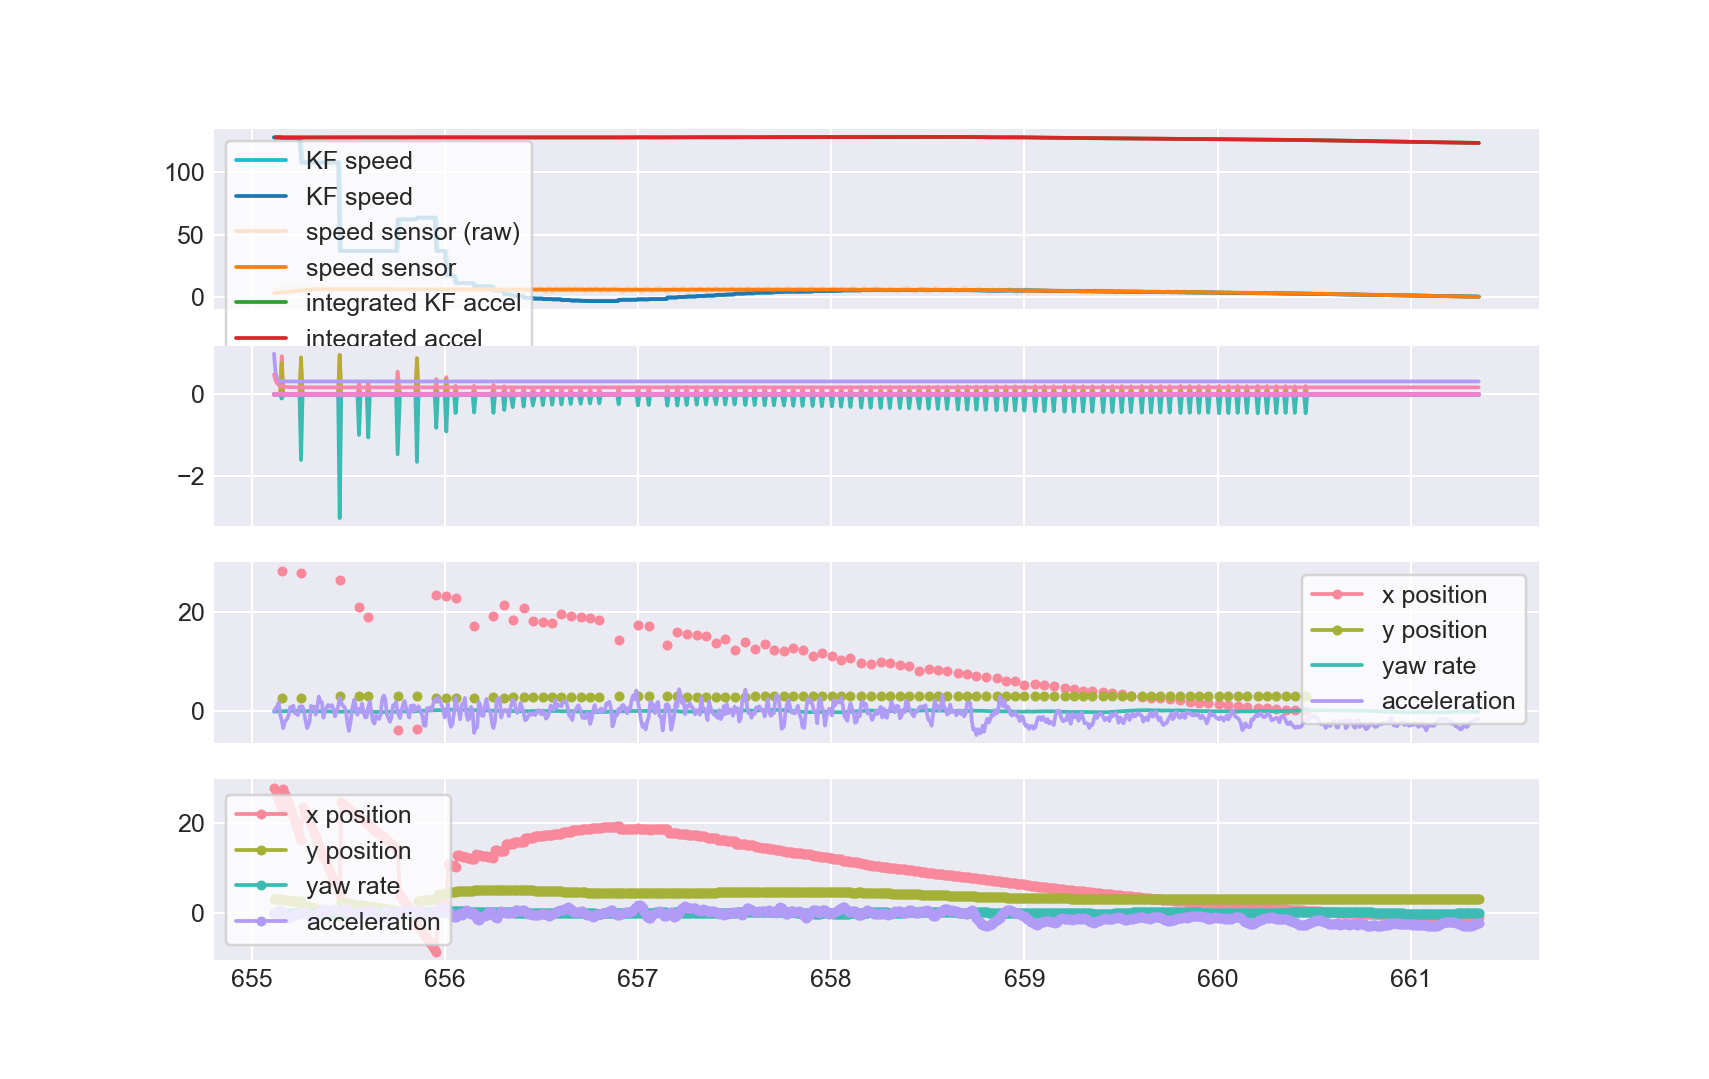

In [225]:
plt.close('all')

x = result.state_estimate
x_ = result.predicted_state_estimate
K = result.kalman_gain

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(9.5, 6))
ax[0].plot(evt.bicycle.time, x_[:, 3], color=color[9], label='KF speed')
ax[0].plot(evt.bicycle.time, x[:, 3], color=color[0], label='KF speed')
ax[0].plot(evt.bicycle.time, evt.bicycle.speed,
           color=color[1], alpha=0.2, label='speed sensor (raw)')
ax[0].plot(evt.bicycle.time, ff.moving_average(evt.bicycle.speed, 55),
           color=color[1], label='speed sensor')
ax[0].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(x[:, 5].squeeze(), dx=T) + x0[3],
           color=color[2], label='integrated KF accel')
ax[0].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(z[:, 3], dx=T) + x0[3],
           color=color[3], label='integrated accel')
ax[0].fill_between(evt.bicycle.time,
                   x[:, 3].squeeze() + np.sqrt(P[:, 3, 3]),
                   x[:, 3].squeeze() - np.sqrt(P[:, 3, 3]),
                   color=color[0], alpha=0.2)
ax[0].legend()

husl_color = sns.husl_palette(K.shape[1]*K.shape[2], l=0.7)
for i in range(K.shape[1]):
    for j in range(K.shape[2]):
        ax[1].plot(evt.bicycle.time,
                   K[:, i, j],
                   color=husl_color[i*K.shape[2] + j])
        
husl_color = sns.husl_palette(4, l=0.7)
ax[2].plot(evt.bicycle.time, z[:, 0],
           color=husl_color[0],
           marker='.',
           label='x position')
ax[2].plot(evt.bicycle.time, z[:, 1],
           color=husl_color[1],
           marker='.',
           label='y position')
ax[2].plot(evt.bicycle.time, z[:, 2],
           color=husl_color[2],
           label='yaw rate')
ax[2].plot(evt.bicycle.time, z[:, 3],
           color=husl_color[3],
           label='acceleration')
ax[2].legend()
        
hx = np.zeros(z.shape)
for k in range(hx.shape[0]):
    hx[k, :] = h(x_[k], wheelbase=0)
    
ax[3].plot(evt.bicycle.time, hx[:, 0],
           marker='.',
           color=husl_color[0],
           label='x position')
ax[3].plot(evt.bicycle.time, hx[:, 1],
           marker='.',
           color=husl_color[1],
           label='y position')
ax[3].plot(evt.bicycle.time, hx[:, 2],
           marker='.',
           color=husl_color[2],
           label='yaw rate')
ax[3].plot(evt.bicycle.time, hx[:, 3],
           marker='.',
           color=husl_color[3],
           label='acceleration')
ax[3].legend()
plt.show()

<IPython.core.display.Javascript object>


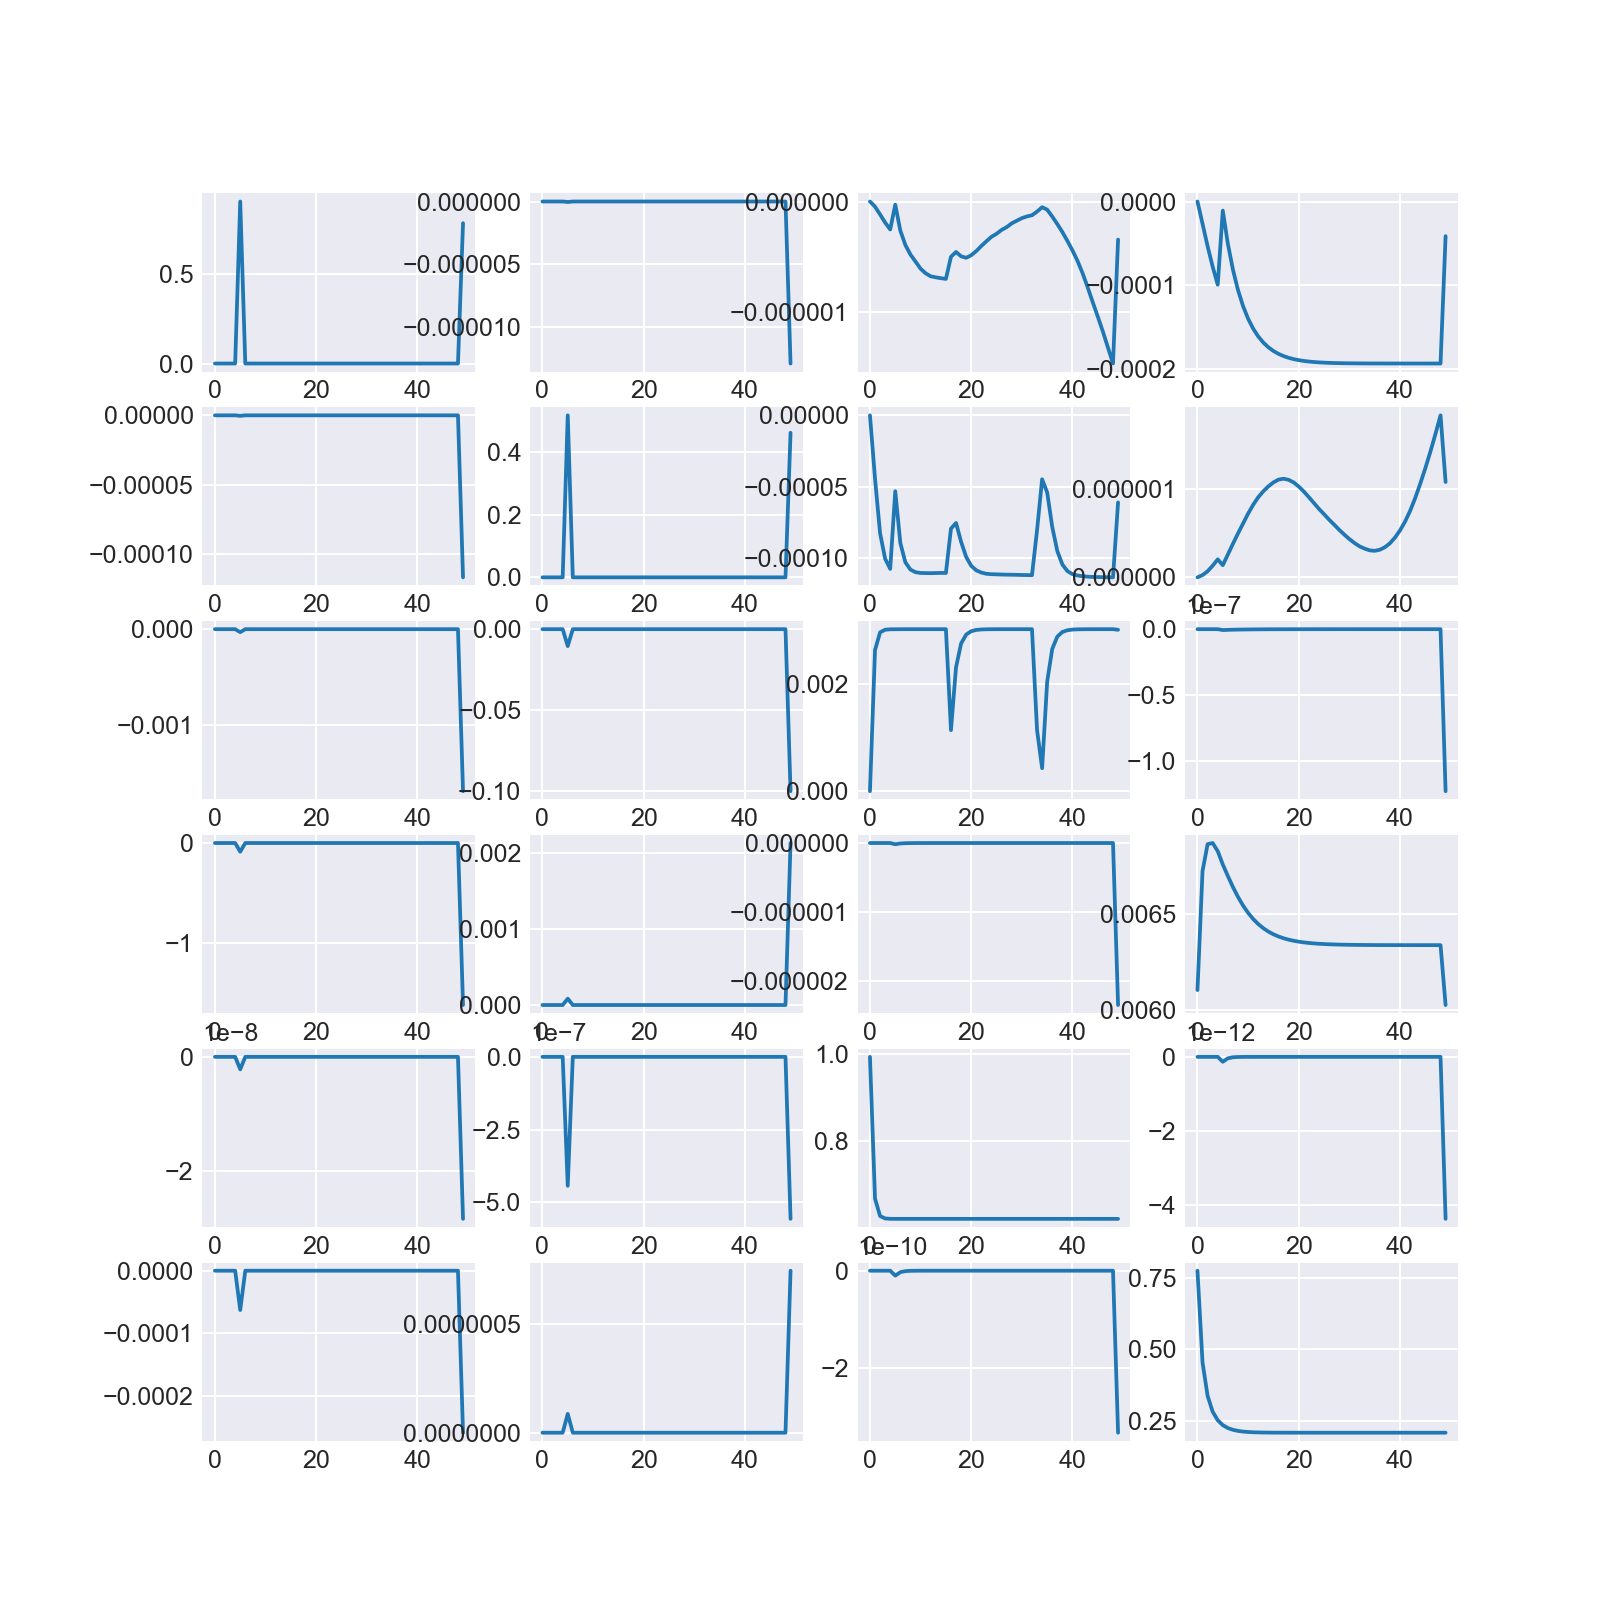

In [97]:
plt.close('all')

K = result.kalman_gain
fig, ax = plt.subplots(K.shape[1], K.shape[2], figsize=(9, 9))
for i in range(K.shape[1]):
    
    for j in range(K.shape[2]):
        ax[i, j].plot(K[:50, i, j])
        
plt.show()